## Auto encoder Med ali & Chahine

Train data shape: (9350, 64, 64, 1)
Test data shape: (9210, 64, 64, 1)


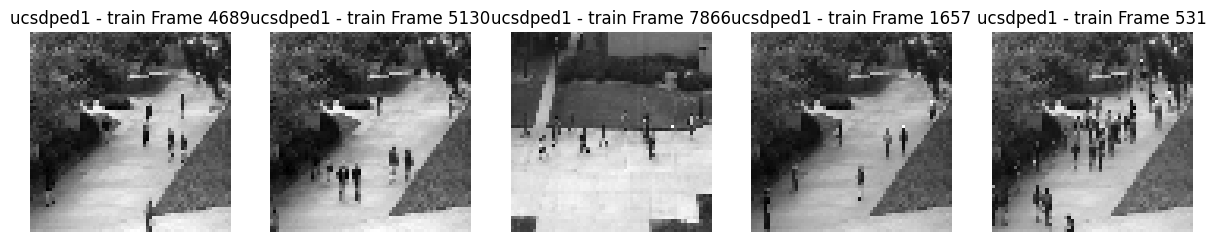

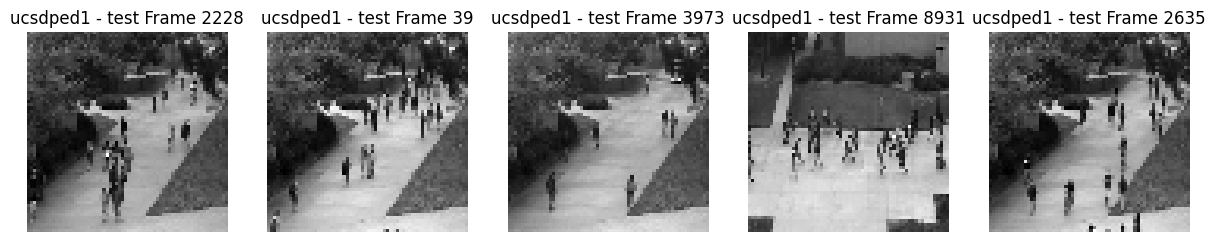

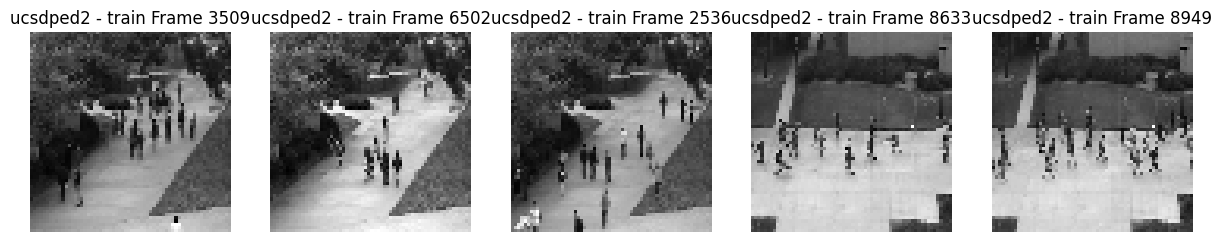

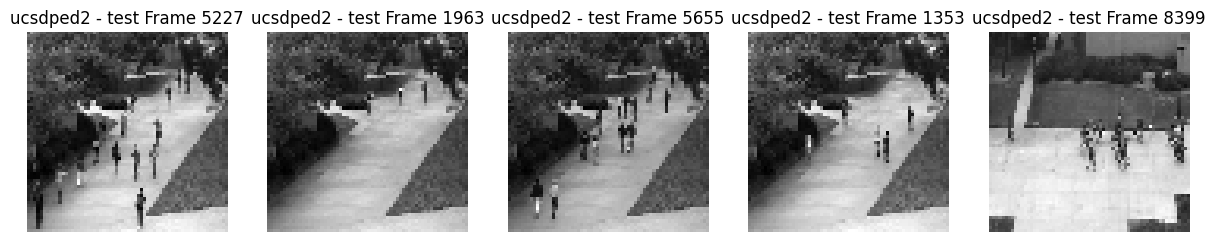

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 0.6501 - val_loss: 0.6063
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.6040 - val_loss: 0.6016
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - loss: 0.6011 - val_loss: 0.5995
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - loss: 0.5991 - val_loss: 0.5985
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - loss: 0.5981 - val_loss: 0.5973
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 127ms/step - loss: 0.5978 - val_loss: 0.5967
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.5966 - val_loss: 0.5963
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - loss: 0.5966 - val_loss: 0.5959
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.5962 - val_loss: 0.5957
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - loss: 0.5959 - val_loss: 0.5954
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.5954 - val_loss: 0.5952
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/st

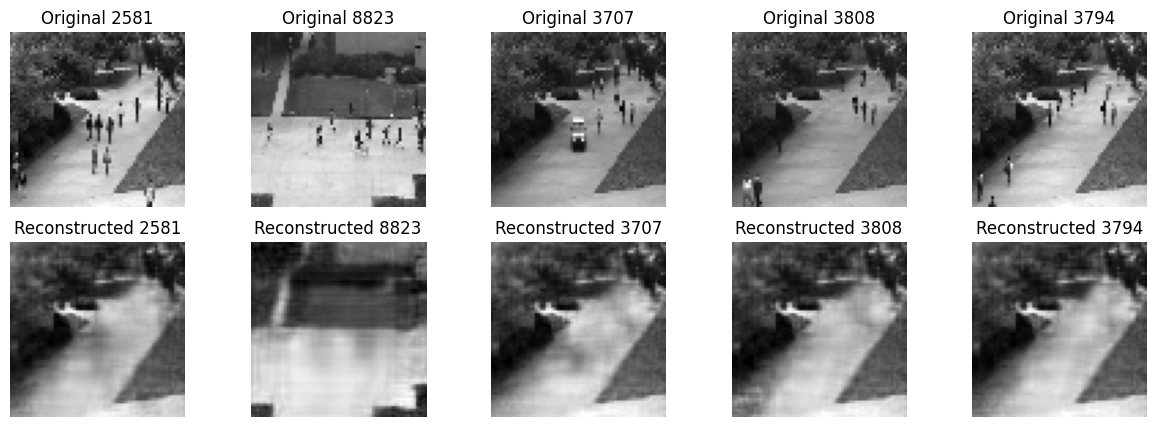

Number of anomalous frames: 461


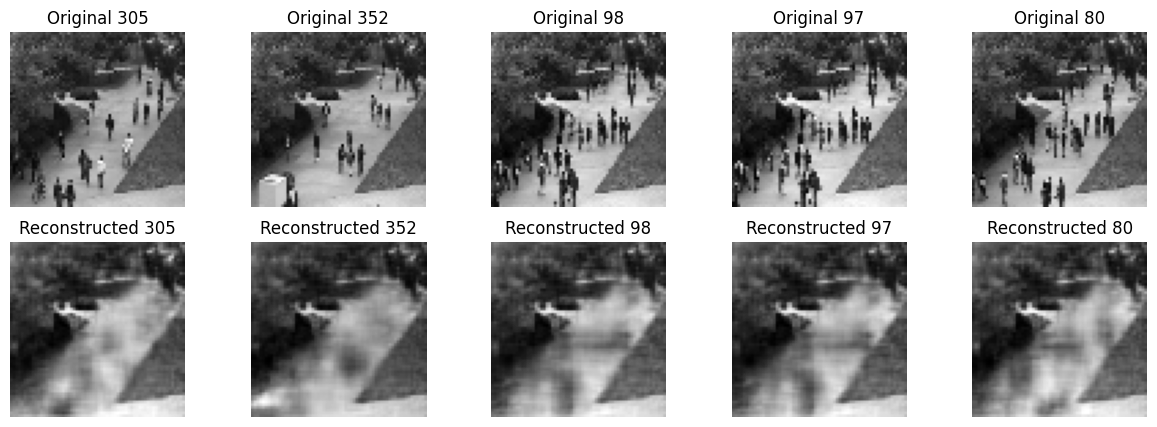

In [28]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import random
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Define the path to the dataset on your local machine
base_folder = 'C:/Users/USER/Desktop/Esprit 5ERPBI5 S1/Deep Learning/Deep Learning Project 5erpbi5/UCSD_Anomaly_Dataset.v1p2'

# Function to load frames from a folder
def load_frames_from_folder(folder_path, frame_size=(64, 64)):
    frames = []
    tif_files = sorted(glob(os.path.join(folder_path, '*.tif')))

    for file in tif_files:
        frame = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize pixel values
        frames.append(frame)

    return np.array(frames)

# Function to load the dataset
def load_dataset(base_path):
    train_data, test_data = [], []

    for subset in ['UCSDped1', 'UCSDped2']:
        train_path = os.path.join(base_path, subset, 'Train')
        test_path = os.path.join(base_path, subset, 'Test')

        # Process train frames
        for folder in sorted(os.listdir(train_path)):
            folder_path = os.path.join(train_path, folder)
            frames = load_frames_from_folder(folder_path)
            train_data.extend(frames)

        # Process test frames
        for folder in sorted(os.listdir(test_path)):
            folder_path = os.path.join(test_path, folder)
            frames = load_frames_from_folder(folder_path)
            test_data.extend(frames)

    train_data = np.array(train_data).reshape(-1, 64, 64, 1)
    test_data = np.array(test_data).reshape(-1, 64, 64, 1)

    return train_data, test_data

# Load the dataset
train_data, test_data = load_dataset(base_folder)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Function to visualize frames
def visualize_frames(data, dataset_name, subset, num_frames=5):
    plt.figure(figsize=(15, 5))
    selected_frames = random.sample(range(len(data)), num_frames)  # Select random frame indices

    for i, frame_idx in enumerate(selected_frames):
        frame = data[frame_idx]

        plt.subplot(1, num_frames, i + 1)
        plt.imshow(frame.squeeze(), cmap='gray')
        plt.title(f"{dataset_name} - {subset} Frame {frame_idx}")
        plt.axis('off')

    plt.show()

# Visualize some frames from ucsdped1 and ucsdped2, train and test sets
visualize_frames(train_data, 'ucsdped1', 'train')
visualize_frames(test_data, 'ucsdped1', 'test')
visualize_frames(test_data, 'ucsdped2', 'train')
visualize_frames(train_data, 'ucsdped2', 'test')

# Build the autoencoder model
input_img = Input(shape=(64, 64, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

# Train the autoencoder
autoencoder.fit(train_data, train_data,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(test_data, test_data))

# Encode and decode some test frames
decoded_imgs = autoencoder.predict(test_data)

# Function to visualize original and reconstructed frames
def visualize_reconstruction(original_data, reconstructed_data, dataset_name, num_frames=5):
    plt.figure(figsize=(15, 5))
    selected_frames = random.sample(range(len(original_data)), num_frames)  # Select random frame indices

    for i, frame_idx in enumerate(selected_frames):
        original_frame = original_data[frame_idx]
        reconstructed_frame = reconstructed_data[frame_idx]

        # Display original frame
        plt.subplot(2, num_frames, i + 1)
        plt.imshow(original_frame.squeeze(), cmap='gray')
        plt.title(f"Original {frame_idx}")
        plt.axis('off')

        # Display reconstructed frame
        plt.subplot(2, num_frames, i + 1 + num_frames)
        plt.imshow(reconstructed_frame.squeeze(), cmap='gray')
        plt.title(f"Reconstructed {frame_idx}")
        plt.axis('off')

    plt.show()

# Visualize some original and reconstructed frames
visualize_reconstruction(test_data, decoded_imgs, 'ucsdped1')

# Calculate reconstruction error for each frame
reconstruction_errors = np.mean(np.square(test_data - decoded_imgs), axis=(1, 2, 3))

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)  # For example, 95th percentile

# Identify frames with reconstruction error above the threshold
anomalous_frames_indices = np.where(reconstruction_errors > threshold)[0]

print(f"Number of anomalous frames: {len(anomalous_frames_indices)}")

# Visualize some anomalous frames
visualize_reconstruction(test_data[anomalous_frames_indices], 
                         decoded_imgs[anomalous_frames_indices], 
                         'Anomalous Frames')


## CNN Ghada & Aziz

Train data shape: (9350, 64, 64, 1)
Test data shape: (9210, 64, 64, 1)
Train sequences shape: (9348, 3, 64, 64, 1)
Test sequences shape: (9208, 3, 64, 64, 1)
Epoch 1/4
526/526 ━━━━━━━━━━━━━━━━━━━━ 167s 310ms/step - loss: 0.0056 - val_loss: 0.0138
Epoch 2/4
526/526 ━━━━━━━━━━━━━━━━━━━━ 165s 314ms/step - loss: 1.3585e-04 - val_loss: 5.8152e-04
Epoch 3/4
526/526 ━━━━━━━━━━━━━━━━━━━━ 160s 305ms/step - loss: 9.8001e-05 - val_loss: 1.6914e-04
Epoch 4/4
526/526 ━━━━━━━━━━━━━━━━━━━━ 169s 321ms/step - loss: 8.8200e-05 - val_loss: 8.9747e-05


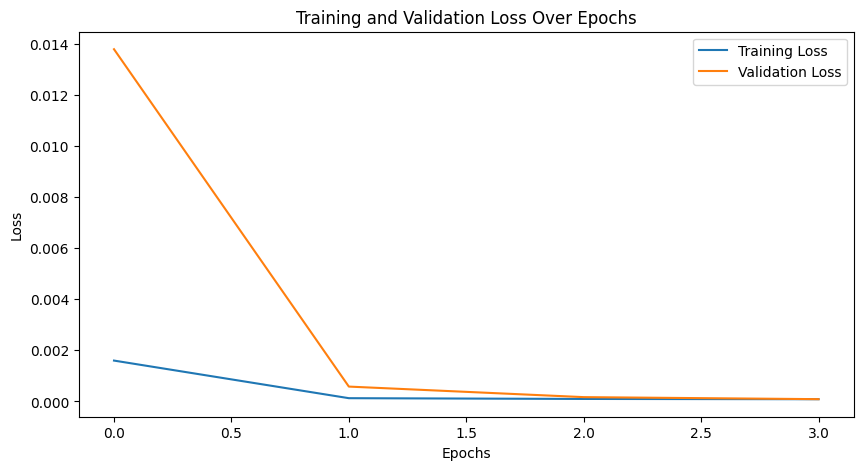

288/288 ━━━━━━━━━━━━━━━━━━━━ 59s 205ms/step - loss: 1.0515e-04
Test Loss: 0.00010160246165469289
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step


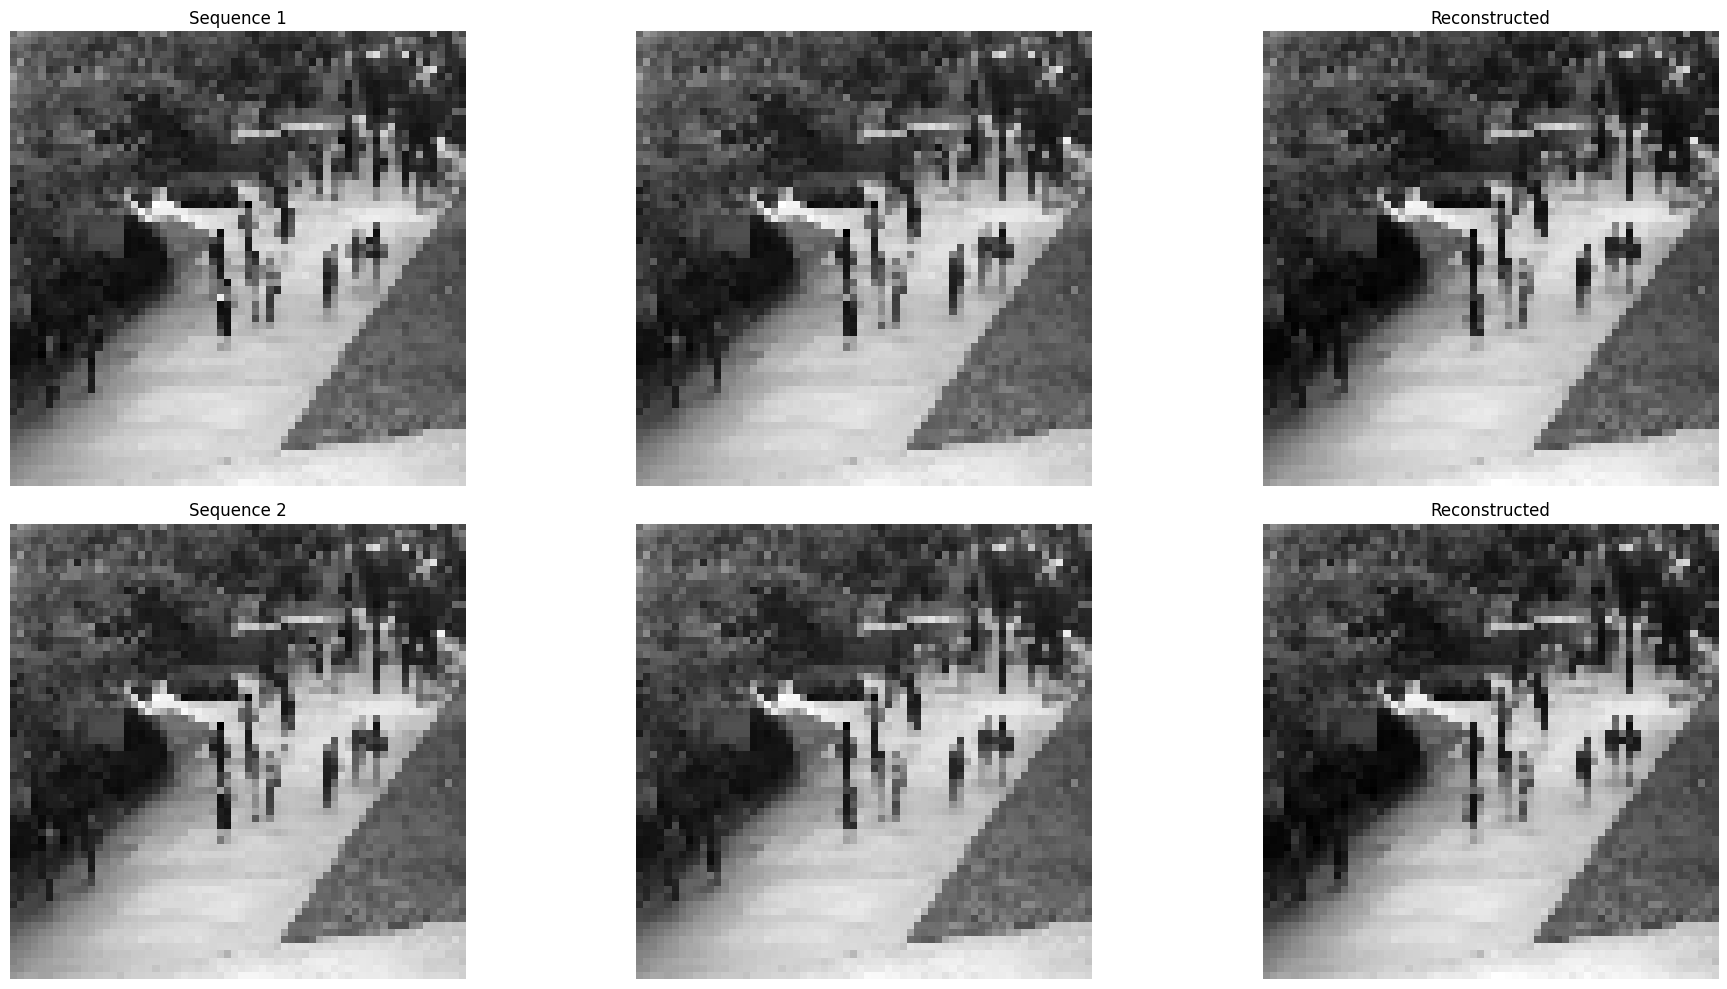

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import ConvLSTM2D, Conv2D, BatchNormalization, TimeDistributed
from keras.optimizers import Adam

# Define the path to the dataset on your local machine
base_folder = 'C:/Users/USER/Desktop/Esprit 5ERPBI5 S1/Deep Learning/Deep Learning Project 5erpbi5/UCSD_Anomaly_Dataset.v1p2'

# Function to load frames from a folder
def load_frames_from_folder(folder_path, frame_size=(64, 64)):
    frames = []
    tif_files = sorted(glob(os.path.join(folder_path, '*.tif')))

    for file in tif_files:
        frame = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize pixel values
        frames.append(frame)

    return np.array(frames)

# Function to load the dataset
def load_dataset(base_path):
    train_data, test_data = [], []

    for subset in ['UCSDped1', 'UCSDped2']:
        train_path = os.path.join(base_path, subset, 'Train')
        test_path = os.path.join(base_path, subset, 'Test')

        # Process train frames
        for folder in sorted(os.listdir(train_path)):
            folder_path = os.path.join(train_path, folder)
            frames = load_frames_from_folder(folder_path)
            train_data.extend(frames)

        # Process test frames
        for folder in sorted(os.listdir(test_path)):
            folder_path = os.path.join(test_path, folder)
            frames = load_frames_from_folder(folder_path)
            test_data.extend(frames)

    train_data = np.array(train_data).reshape(-1, 64, 64, 1)
    test_data = np.array(test_data).reshape(-1, 64, 64, 1)

    return train_data, test_data

# Load the dataset
train_data, test_data = load_dataset(base_folder)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Function to create sequences of frames
def create_sequences(data, sequence_length=10):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Create sequences of frames
sequence_length = 3  # Reduced sequence length
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

print("Train sequences shape:", train_sequences.shape)  # Check sequences shape
print("Test sequences shape:", test_sequences.shape)    # Check sequences shape

# Ensure that the sequences are not empty and have the expected shape
if train_sequences.shape[0] == 0:
    raise ValueError("Train sequences are empty! Check the sequence creation process.")
if test_sequences.shape[0] == 0:
    raise ValueError("Test sequences are empty! Check the sequence creation process.")

# Define the ConvLSTM model with reduced complexity
model = Sequential([
    ConvLSTM2D(filters=32, kernel_size=(3, 3), input_shape=(sequence_length, 64, 64, 1),
               padding='same', return_sequences=True, activation='relu'),
    BatchNormalization(),
    ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True, activation='relu'),
    BatchNormalization(),
    TimeDistributed(Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same'))
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model with a reduced batch size
history = model.fit(train_sequences, train_sequences, epochs=4, batch_size=16, validation_split=0.1)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the model on the test sequences
test_loss = model.evaluate(test_sequences, test_sequences)
print("Test Loss:", test_loss)

num_sequences = 2  # Reduced number of sequences for faster plotting
sequences_to_plot = test_sequences[:num_sequences]
reconstructed_sequences = model.predict(test_sequences[:num_sequences])

# Plot original and reconstructed frames for comparison
fig, axes = plt.subplots(num_sequences, sequence_length, figsize=(20, 10))
for i in range(num_sequences):
    for j in range(sequence_length):
        # Original frame
        axes[i, j].imshow(sequences_to_plot[i][j].reshape(64, 64), cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f'Sequence {i+1}')
        if j == sequence_length - 1:
            axes[i, j].imshow(reconstructed_sequences[i][j].reshape(64, 64), cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title('Reconstructed')

plt.tight_layout()
plt.show()


## RNN Med ali & Chahine

Train data shape: (9350, 64, 64, 1)
Test data shape: (9210, 64, 64, 1)
Train sequences shape: (9341, 10, 64, 64, 1)
Test sequences shape: (9201, 10, 64, 64, 1)
Flattened train sequences shape: (9341, 10, 4096)
Flattened test sequences shape: (9201, 10, 4096)
Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - loss: 0.0323 - val_loss: 0.0054
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0037 - val_loss: 0.0073
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0036 - val_loss: 0.0075
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0036 - val_loss: 0.0089
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 0.0035 - val_loss: 0.0075
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0035 - val_loss: 0.0089
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0035 - val_loss: 0.0093
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 0.0035 - val_loss: 0.0091
Epoch 9/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 3

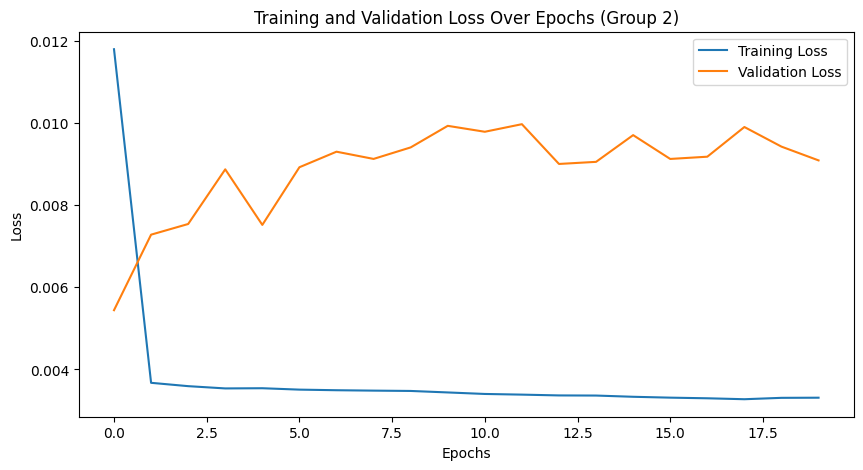

288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0116
Test Loss (Group 2): 0.010812041349709034
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 705ms/step


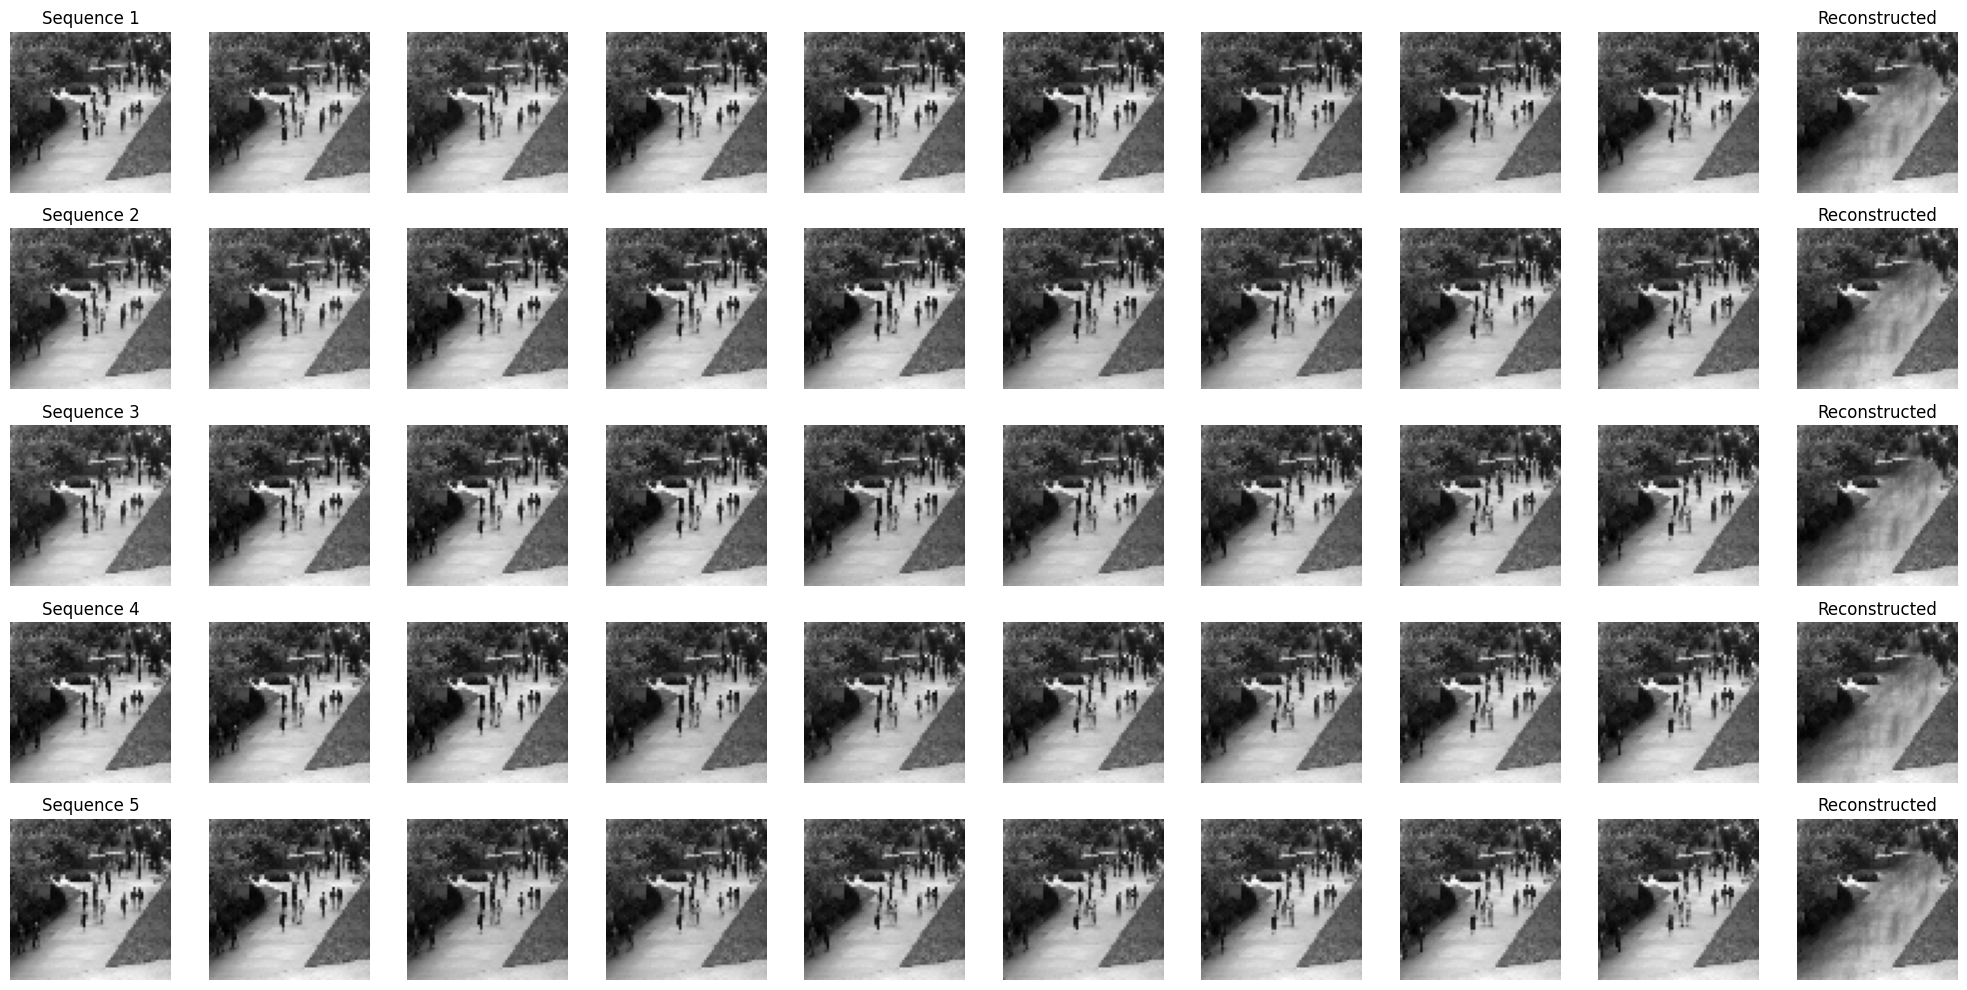

In [27]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import GRU, Dense, TimeDistributed, RepeatVector, Flatten, Reshape, Dropout
from keras.optimizers import Adam

# Define the path to the dataset on your local machine
base_folder = 'C:/Users/USER/Desktop/Esprit 5ERPBI5 S1/Deep Learning/Deep Learning Project 5erpbi5/UCSD_Anomaly_Dataset.v1p2'

# Function to load frames from a folder
def load_frames_from_folder(folder_path, frame_size=(64, 64)):
    frames = []
    tif_files = sorted(glob(os.path.join(folder_path, '*.tif')))
    for file in tif_files:
        frame = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize pixel values
        frames.append(frame)
    return np.array(frames)

# Function to load the dataset
def load_dataset(base_path):
    train_data, test_data = [], []
    for subset in ['UCSDped1', 'UCSDped2']:
        train_path = os.path.join(base_path, subset, 'Train')
        test_path = os.path.join(base_path, subset, 'Test')
        
        # Process train frames
        for folder in sorted(os.listdir(train_path)):
            folder_path = os.path.join(train_path, folder)
            frames = load_frames_from_folder(folder_path)
            train_data.extend(frames)

        # Process test frames
        for folder in sorted(os.listdir(test_path)):
            folder_path = os.path.join(test_path, folder)
            frames = load_frames_from_folder(folder_path)
            test_data.extend(frames)

    train_data = np.array(train_data).reshape(-1, 64, 64, 1)
    test_data = np.array(test_data).reshape(-1, 64, 64, 1)

    return train_data, test_data

# Load the dataset
train_data, test_data = load_dataset(base_folder)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Function to create sequences of frames
def create_sequences(data, sequence_length=10):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Create sequences of frames
sequence_length = 10
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

print("Train sequences shape:", train_sequences.shape)
print("Test sequences shape:", test_sequences.shape)

# Flatten the spatial dimensions for input to RNN
train_sequences_flat = train_sequences.reshape(train_sequences.shape[0], sequence_length, -1)
test_sequences_flat = test_sequences.reshape(test_sequences.shape[0], sequence_length, -1)

print("Flattened train sequences shape:", train_sequences_flat.shape)
print("Flattened test sequences shape:", test_sequences_flat.shape)

# Define a new RNN model (GRU instead of LSTM, added Dropout and reduced layer sizes)
model_group2 = Sequential([
    GRU(64, activation='relu', input_shape=(sequence_length, 64*64), return_sequences=True),
    Dropout(0.3),  # Dropout for regularization
    GRU(32, activation='relu', return_sequences=False),
    RepeatVector(sequence_length),
    GRU(32, activation='relu', return_sequences=True),
    GRU(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(64*64, activation='tanh')),  # Changed to tanh activation
    TimeDistributed(Reshape((64, 64, 1)))
])

# Compile the model
model_group2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history_group2 = model_group2.fit(train_sequences_flat, train_sequences, epochs=20, batch_size=32, validation_split=0.1)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_group2.history['loss'], label='Training Loss')
plt.plot(history_group2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs (Group 2)')
plt.legend()
plt.show()

# Evaluate the model on the test sequences
test_loss_group2 = model_group2.evaluate(test_sequences_flat, test_sequences)
print("Test Loss (Group 2):", test_loss_group2)

# Select a few sequences from the test set
num_sequences = 5
sequences_to_plot_group2 = test_sequences[:num_sequences]
reconstructed_sequences_group2 = model_group2.predict(test_sequences_flat[:num_sequences])

# Plot original and reconstructed frames for comparison
fig, axes = plt.subplots(num_sequences, sequence_length, figsize=(20, 10))
for i in range(num_sequences):
    for j in range(sequence_length):
        # Original frame
        axes[i, j].imshow(sequences_to_plot_group2[i][j].reshape(64, 64), cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f'Sequence {i+1}')
        if j == sequence_length - 1:
            axes[i, j].imshow(reconstructed_sequences_group2[i][j].reshape(64, 64), cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title('Reconstructed')

plt.tight_layout()
plt.show()


## RNN Kacem & Ines

Train data shape: (9350, 64, 64, 1)
Test data shape: (9210, 64, 64, 1)
Train sequences shape: (9341, 10, 64, 64, 1)
Test sequences shape: (9201, 10, 64, 64, 1)
Flattened train sequences shape: (9341, 10, 4096)
Flattened test sequences shape: (9201, 10, 4096)
Epoch 1/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - loss: 0.0171 - val_loss: 0.0017
Epoch 2/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 3/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 4/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 5/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 6/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 7/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 8/20
263/263 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 9/20
263/263 ━━━━━━━━━━━━━━━━━━

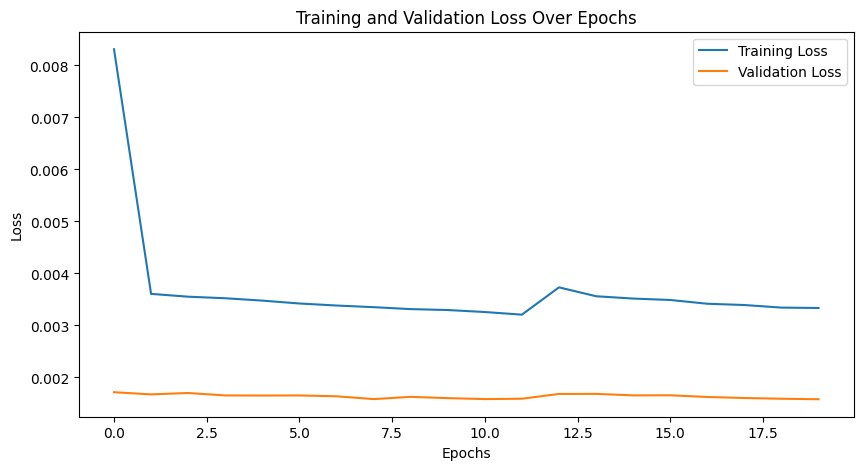

288/288 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0062
Test Loss: 0.004940968006849289
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step


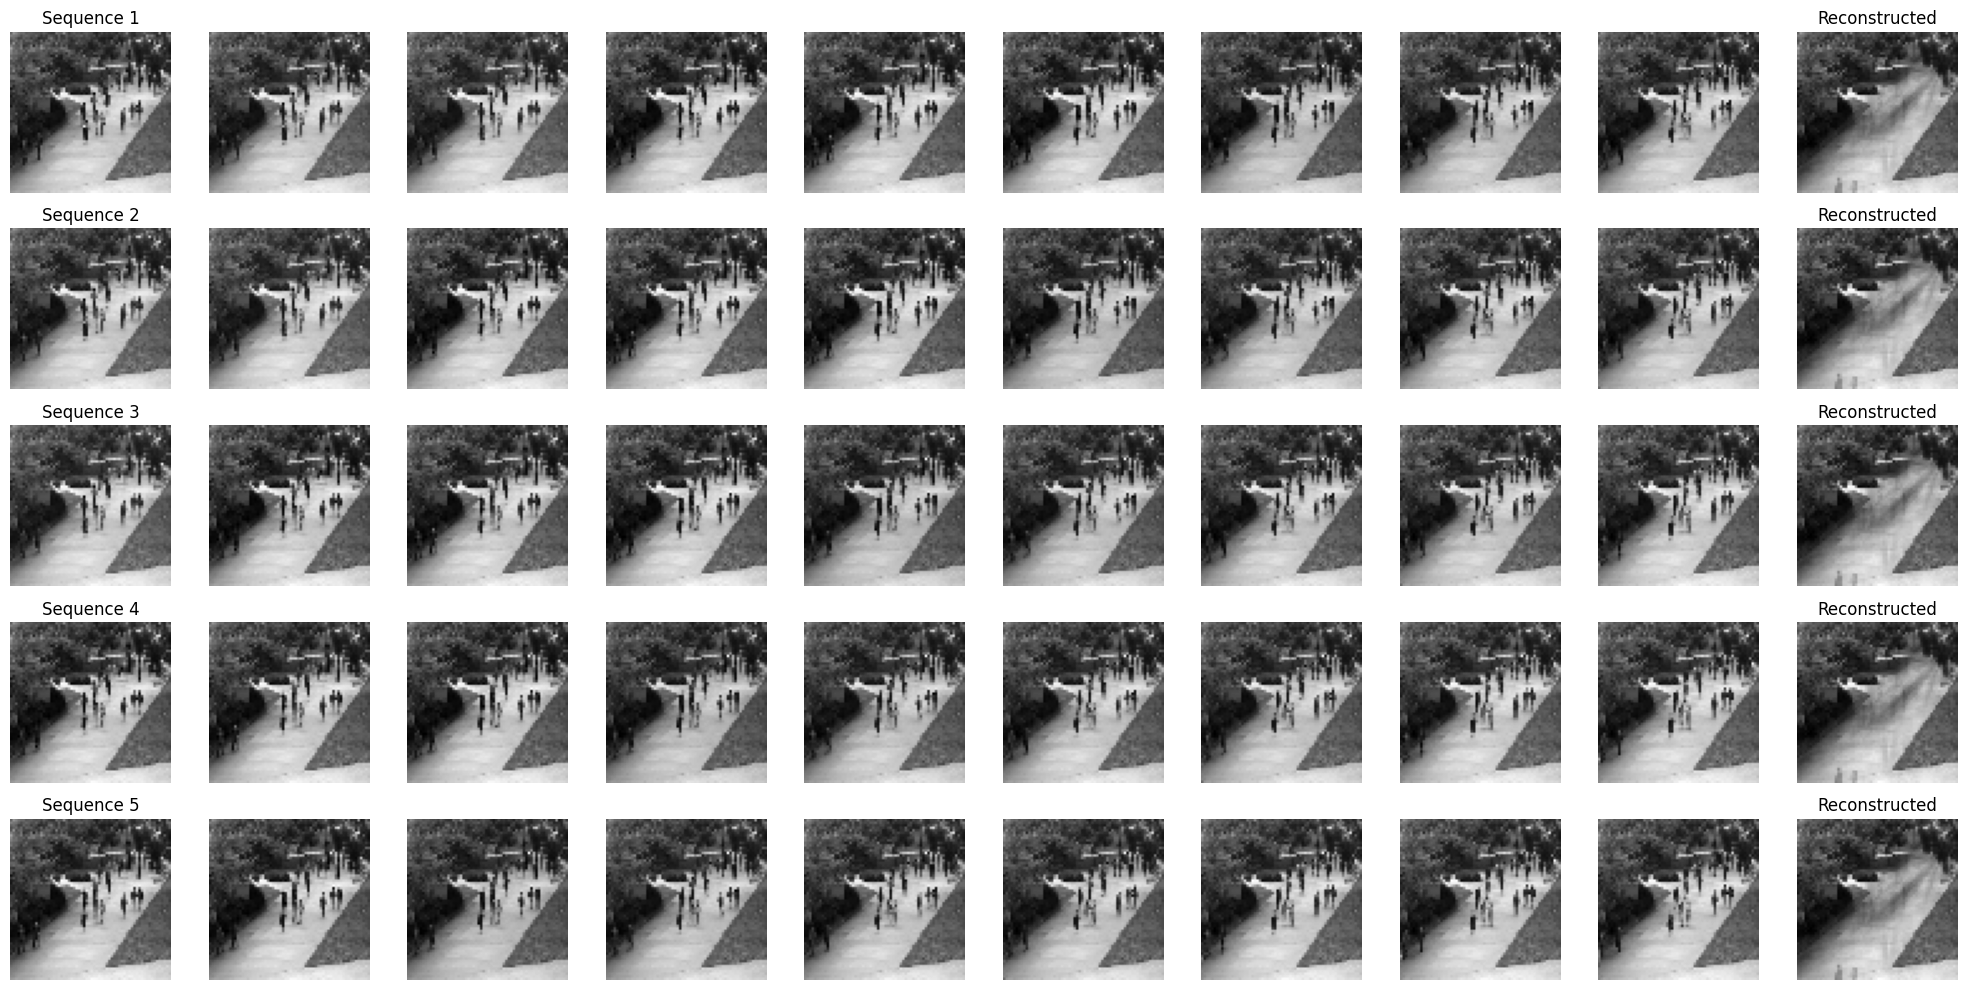

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, RepeatVector, Flatten, Reshape
from keras.optimizers import Adam

# Define the path to the dataset on your local machine
base_folder = 'C:/Users/USER/Desktop/Esprit 5ERPBI5 S1/Deep Learning/Deep Learning Project 5erpbi5/UCSD_Anomaly_Dataset.v1p2'

# Function to load frames from a folder
def load_frames_from_folder(folder_path, frame_size=(64, 64)):
    frames = []
    tif_files = sorted(glob(os.path.join(folder_path, '*.tif')))
    for file in tif_files:
        frame = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize pixel values
        frames.append(frame)
    return np.array(frames)

# Function to load the dataset
def load_dataset(base_path):
    train_data, test_data = [], []
    for subset in ['UCSDped1', 'UCSDped2']:
        train_path = os.path.join(base_path, subset, 'Train')
        test_path = os.path.join(base_path, subset, 'Test')
        
        # Process train frames
        for folder in sorted(os.listdir(train_path)):
            folder_path = os.path.join(train_path, folder)
            frames = load_frames_from_folder(folder_path)
            train_data.extend(frames)

        # Process test frames
        for folder in sorted(os.listdir(test_path)):
            folder_path = os.path.join(test_path, folder)
            frames = load_frames_from_folder(folder_path)
            test_data.extend(frames)

    train_data = np.array(train_data).reshape(-1, 64, 64, 1)
    test_data = np.array(test_data).reshape(-1, 64, 64, 1)

    return train_data, test_data

# Load the dataset
train_data, test_data = load_dataset(base_folder)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Function to create sequences of frames
def create_sequences(data, sequence_length=10):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Create sequences of frames
sequence_length = 10
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

print("Train sequences shape:", train_sequences.shape)
print("Test sequences shape:", test_sequences.shape)

# Flatten the spatial dimensions for input to LSTM
train_sequences_flat = train_sequences.reshape(train_sequences.shape[0], sequence_length, -1)
test_sequences_flat = test_sequences.reshape(test_sequences.shape[0], sequence_length, -1)

print("Flattened train sequences shape:", train_sequences_flat.shape)
print("Flattened test sequences shape:", test_sequences_flat.shape)

# Define the model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(sequence_length, 64*64), return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(64*64, activation='sigmoid')),
    TimeDistributed(Reshape((64, 64, 1)))
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the model
history = model.fit(train_sequences_flat, train_sequences, epochs=20, batch_size=32, validation_split=0.1)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate the model on the test sequences
test_loss = model.evaluate(test_sequences_flat, test_sequences)
print("Test Loss:", test_loss)

# Select a few sequences from the test set
num_sequences = 5
sequences_to_plot = test_sequences[:num_sequences]
reconstructed_sequences = model.predict(test_sequences_flat[:num_sequences])

# Plot original and reconstructed frames for comparison
fig, axes = plt.subplots(num_sequences, sequence_length, figsize=(20, 10))
for i in range(num_sequences):
    for j in range(sequence_length):
        # Original frame
        axes[i, j].imshow(sequences_to_plot[i][j].reshape(64, 64), cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f'Sequence {i+1}')
        if j == sequence_length - 1:
            axes[i, j].imshow(reconstructed_sequences[i][j].reshape(64, 64), cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title('Reconstructed')

plt.tight_layout()
plt.show()


## CNN Kacem & Ines


Train data shape: (9350, 32, 32, 1)
Test data shape: (9210, 32, 32, 1)
Train sequences shape: (9341, 10, 32, 32, 1)
Test sequences shape: (9201, 10, 32, 32, 1)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 10, 32, 32, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 10, 1, 1, 512)  │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 10, 512)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 10, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,699,393 (59.89 MB)

 Trainable params: 984,705 (3.76 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 414s 350ms/step - accuracy: 0.9860 - loss: 0.0430 - val_accuracy: 1.0000 - val_loss: 2.3263e-19
Epoch 2/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 393s 337ms/step - accuracy: 1.0000 - loss: 2.1378e-08 - val_accuracy: 1.0000 - val_loss: 7.9562e-23
Epoch 3/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 387s 332ms/step - accuracy: 1.0000 - loss: 1.4825e-09 - val_accuracy: 1.0000 - val_loss: 2.4958e-23
Epoch 4/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 389s 334ms/step - accuracy: 1.0000 - loss: 2.2719e-10 - val_accuracy: 1.0000 - val_loss: 1.8258e-23
Epoch 5/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 389s 333ms/step - accuracy: 1.0000 - loss: 1.4283e-10 - val_accuracy: 1.0000 - val_loss: 5.3485e-24
Epoch 6/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 390s 334ms/step - accuracy: 1.0000 - loss: 1.3450e-09 - val_accuracy: 1.0000 - val_loss: 2.3986e-25
Epoch 7/20
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 397s 340ms/step - accuracy: 1.0000 - loss: 5.0904e-13 - val_accuracy: 1.0000 - val_loss: 2.2758e-25
Epoch 8/20

TypeError: unsupported format string passed to numpy.ndarray.__format__

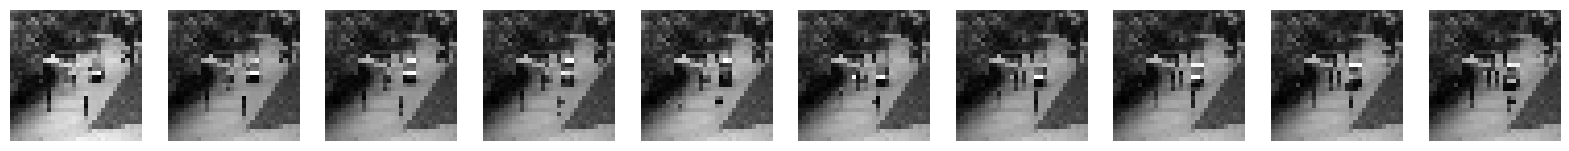

In [ ]:
import os
import numpy as np
import cv2
from glob import glob   
import matplotlib.pyplot as plt
import random
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import Sequence

# Define the path to the dataset on your local machine
base_folder = 'C:/Users/USER/Desktop/Esprit 5ERPBI5 S1/Deep Learning/Deep Learning Project 5erpbi5/UCSD_Anomaly_Dataset.v1p2'

# Function to load frames from a folder
def load_frames_from_folder(folder_path, frame_size=(32, 32)):
    frames = []
    tif_files = sorted(glob(os.path.join(folder_path, '*.tif')))

    for file in tif_files:
        frame = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize pixel values
        frames.append(frame)

    return np.array(frames)

# Function to load the dataset
def load_dataset(base_path):
    train_data, test_data = [], []

    for subset in ['UCSDped1', 'UCSDped2']:
        train_path = os.path.join(base_path, subset, 'Train')
        test_path = os.path.join(base_path, subset, 'Test')

        # Process train frames
        for folder in sorted(os.listdir(train_path)):
            folder_path = os.path.join(train_path, folder)
            frames = load_frames_from_folder(folder_path)
            train_data.extend(frames)

        # Process test frames
        for folder in sorted(os.listdir(test_path)):
            folder_path = os.path.join(test_path, folder)
            frames = load_frames_from_folder(folder_path)
            test_data.extend(frames)

    train_data = np.array(train_data).reshape(-1, 32, 32, 1)
    test_data = np.array(test_data).reshape(-1, 32, 32, 1)

    return train_data, test_data

# Load the dataset
train_data, test_data = load_dataset(base_folder)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Function to create sequences of frames
def create_sequences(data, sequence_length=10):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Create sequences of frames
sequence_length = 10
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

print("Train sequences shape:", train_sequences.shape)
print("Test sequences shape:", test_sequences.shape)

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=8, sequence_length=10):
        self.data = data
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.indices = np.arange(len(data) - sequence_length + 1)

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = np.array([self.data[i:i + self.sequence_length] for i in batch_indices])
        batch_data_vgg = np.repeat(batch_data, 3, axis=-1)  # Duplicate channels
        return batch_data_vgg, np.zeros((batch_data_vgg.shape[0], 1))

# Create data generators
train_generator = DataGenerator(train_data, batch_size=8, sequence_length=sequence_length)
test_generator = DataGenerator(test_data, batch_size=8, sequence_length=sequence_length)

# Define the VGG16-based model with dropout for regularization
def create_vgg16_lstm_model(input_shape):
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    for layer in vgg16.layers:
        layer.trainable = False

    inputs = Input(shape=input_shape)
    time_distributed = TimeDistributed(vgg16)(inputs)
    time_distributed = TimeDistributed(Flatten())(time_distributed)
    lstm = LSTM(256, activation='relu', return_sequences=True)(time_distributed)
    lstm = Dropout(0.5)(lstm)
    lstm = LSTM(128, activation='relu', return_sequences=False)(lstm)
    lstm = Dropout(0.5)(lstm)
    dense = Dense(1, activation='sigmoid')(lstm)

    model = Model(inputs, dense)
    return model

# Create the model
input_shape = (sequence_length, 32, 32, 3)  # Adjusted to 3 channels for VGG16
model = create_vgg16_lstm_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Define the callbacks
checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model using the data generators
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=20, callbacks=[checkpoint, early_stopping])

# Visualize some results
def visualize_results(test_sequences, test_generator, model):
    predictions = model.predict(test_generator)

    for i in range(10):  # Display 10 random sequences
        idx = random.randint(0, len(test_sequences) - 1)
        sequence = test_sequences[idx]
        prediction = predictions[idx]

        fig, axes = plt.subplots(1, sequence_length, figsize=(20, 5))
        for j in range(sequence_length):
            axes[j].imshow(sequence[j].reshape(32, 32), cmap='gray')
            axes[j].axis('off')
        plt.suptitle(f'Prediction: {prediction:.4f}')
        plt.show()

# Visualize the results
visualize_results(test_sequences, test_generator, model)


##  Autoencoder Ghada & Aziz

Train data shape: (9350, 64, 64, 1)
Test data shape: (9210, 64, 64, 1)


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 293ms/step - loss: 0.6644 - val_loss: 0.6041
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - loss: 0.6030 - val_loss: 0.6009
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 295ms/step - loss: 0.5998 - val_loss: 0.5980
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 306ms/step - loss: 0.5981 - val_loss: 0.5965
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 25s 345ms/step - loss: 0.5963 - val_loss: 0.5953
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 26s 348ms/step - loss: 0.5953 - val_loss: 0.5944
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 26s 347ms/step - loss: 0.5948 - val_loss: 0.5937
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 308ms/step - loss: 0.5943 - val_loss: 0.5933
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 23s 311ms/step - loss: 0.5938 - val_loss: 0.5929
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 22s 295ms/step - loss: 0.5931 - val_loss: 0.5925
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 21s 287ms/step - loss: 0.5933 - val_loss: 0.5922
Epoch 12/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 21

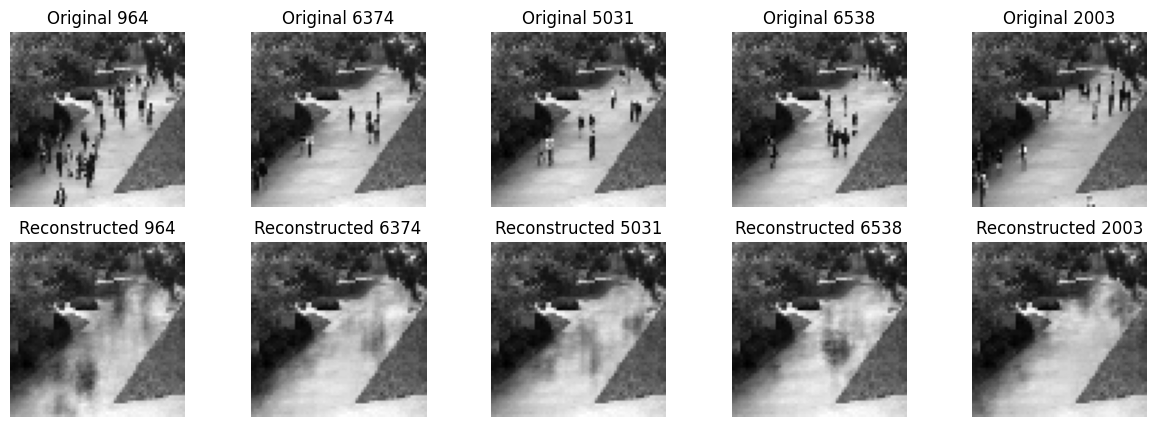

In [44]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import random
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose, LeakyReLU
from keras.optimizers import Adam

# Define the path to the dataset on your local machine
base_folder = 'C:/Users/USER/Desktop/Esprit 5ERPBI5 S1/Deep Learning/Deep Learning Project 5erpbi5/UCSD_Anomaly_Dataset.v1p2'

# Function to load frames from a folder
def load_frames_from_folder(folder_path, frame_size=(64, 64)):
    frames = []
    tif_files = sorted(glob(os.path.join(folder_path, '*.tif')))

    for file in tif_files:
        frame = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize pixel values
        frames.append(frame)

    return np.array(frames)

# Function to load the dataset
def load_dataset(base_path):
    train_data, test_data = [], []

    for subset in ['UCSDped1', 'UCSDped2']:
        train_path = os.path.join(base_path, subset, 'Train')
        test_path = os.path.join(base_path, subset, 'Test')

        # Process train frames
        for folder in sorted(os.listdir(train_path)):
            folder_path = os.path.join(train_path, folder)
            frames = load_frames_from_folder(folder_path)
            train_data.extend(frames)

        # Process test frames
        for folder in sorted(os.listdir(test_path)):
            folder_path = os.path.join(test_path, folder)
            frames = load_frames_from_folder(folder_path)
            test_data.extend(frames)

    train_data = np.array(train_data).reshape(-1, 64, 64, 1)
    test_data = np.array(test_data).reshape(-1, 64, 64, 1)

    return train_data, test_data

# Load the dataset
train_data, test_data = load_dataset(base_folder)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Build the new autoencoder model for group 2
input_img = Input(shape=(64, 64, 1))

# Encoder
x = Conv2D(64, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.2), padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(encoded)

# Decoder (using Conv2DTranspose instead of UpSampling2D)
x = Conv2DTranspose(16, (3, 3), strides=(2, 2), activation=LeakyReLU(alpha=0.2), padding='same')(encoded)
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation=LeakyReLU(alpha=0.2), padding='same')(x)
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation=LeakyReLU(alpha=0.2), padding='same')(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder_group2 = Model(input_img, decoded)
autoencoder_group2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')


# Train the new autoencoder
autoencoder_group2.fit(train_data, train_data,
                       epochs=50,
                       batch_size=128,
                       shuffle=True,
                       validation_data=(test_data, test_data))

# Encode and decode some test frames
decoded_imgs_group2 = autoencoder_group2.predict(test_data)

# Function to visualize original and reconstructed frames
def visualize_reconstruction(original_data, reconstructed_data, dataset_name, num_frames=5):
    plt.figure(figsize=(15, 5))
    selected_frames = random.sample(range(len(original_data)), num_frames)  # Select random frame indices

    for i, frame_idx in enumerate(selected_frames):
        original_frame = original_data[frame_idx]
        reconstructed_frame = reconstructed_data[frame_idx]

        # Display original frame
        plt.subplot(2, num_frames, i + 1)
        plt.imshow(original_frame.squeeze(), cmap='gray')
        plt.title(f"Original {frame_idx}")
        plt.axis('off')

        # Display reconstructed frame
        plt.subplot(2, num_frames, i + 1 + num_frames)
        plt.imshow(reconstructed_frame.squeeze(), cmap='gray')
        plt.title(f"Reconstructed {frame_idx}")
        plt.axis('off')

    plt.show()

# Visualize some original and reconstructed frames from group 2 model
visualize_reconstruction(test_data, decoded_imgs_group2, 'Group 2')


## Other CNNs Models

Train data shape: (9350, 32, 32, 1)
Test data shape: (9210, 32, 32, 1)
Train sequences shape: (9341, 10, 32, 32, 1)
Test sequences shape: (9201, 10, 32, 32, 1)


Model: "functional_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 10, 32, 32, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_29             │ (None, 10, 1, 1, 512)  │    14,714,688 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_30             │ (None, 10, 512)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 10, 256)        │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,699,393 (59.89 MB)

 Trainable params: 984,705 (3.76 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/3
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 436s 369ms/step - accuracy: 1.0000 - loss: 0.0257 - val_accuracy: 1.0000 - val_loss: 6.4992e-09
Epoch 2/3
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 407s 349ms/step - accuracy: 1.0000 - loss: 3.7486e-09 - val_accuracy: 1.0000 - val_loss: 1.4853e-09
Epoch 3/3
1167/1167 ━━━━━━━━━━━━━━━━━━━━ 406s 348ms/step - accuracy: 1.0000 - loss: 8.6541e-10 - val_accuracy: 1.0000 - val_loss: 5.9574e-10
1150/1150 ━━━━━━━━━━━━━━━━━━━━ 202s 174ms/step


TypeError: unsupported format string passed to numpy.ndarray.__format__

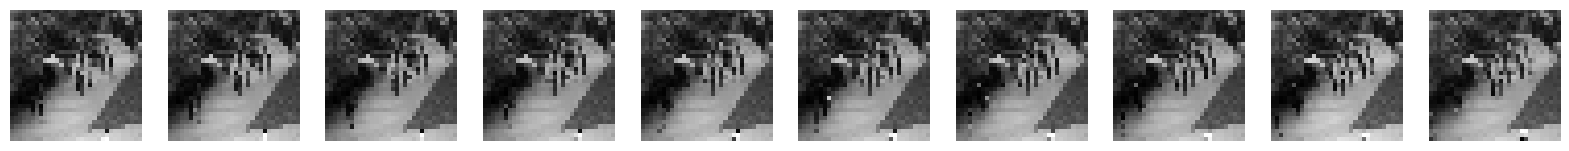

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import random
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import Sequence

# Define the path to the dataset on your local machine
base_folder = 'C:/Users/USER/Desktop/Esprit 5ERPBI5 S1/Deep Learning/Deep Learning Project 5erpbi5/UCSD_Anomaly_Dataset.v1p2'

# Function to load frames from a folder
def load_frames_from_folder(folder_path, frame_size=(32, 32), max_frames=100):
    frames = []
    tif_files = sorted(glob(os.path.join(folder_path, '*.tif')))[:max_frames]  # Limit the number of frames

    for file in tif_files:
        frame = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize pixel values
        frames.append(frame)

    return np.array(frames)

# Function to load the dataset
def load_dataset(base_path, max_frames=100):
    train_data, test_data = [], []

    for subset in ['UCSDped1', 'UCSDped2']:
        train_path = os.path.join(base_path, subset, 'Train')
        test_path = os.path.join(base_path, subset, 'Test')

        # Process train frames
        for folder in sorted(os.listdir(train_path)):
            folder_path = os.path.join(train_path, folder)
            frames = load_frames_from_folder(folder_path, max_frames=max_frames)
            train_data.extend(frames)

        # Process test frames
        for folder in sorted(os.listdir(test_path)):
            folder_path = os.path.join(test_path, folder)
            frames = load_frames_from_folder(folder_path, max_frames=max_frames)
            test_data.extend(frames)

    train_data = np.array(train_data).reshape(-1, 32, 32, 1)
    test_data = np.array(test_data).reshape(-1, 32, 32, 1)

    return train_data, test_data

# Load the dataset
train_data, test_data = load_dataset(base_folder, max_frames=100)  # Load only 100 frames per folder
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Function to create sequences of frames
def create_sequences(data, sequence_length=10):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Create sequences of frames
sequence_length = 10
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

print("Train sequences shape:", train_sequences.shape)
print("Test sequences shape:", test_sequences.shape)

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=4, sequence_length=10):  # Reduced batch size
        self.data = data
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.indices = np.arange(len(data) - sequence_length + 1)

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = np.array([self.data[i:i + self.sequence_length] for i in batch_indices])
        batch_data_vgg = np.repeat(batch_data, 3, axis=-1)  # Duplicate channels
        return batch_data_vgg, np.zeros((batch_data_vgg.shape[0], 1))

# Create data generators
train_generator = DataGenerator(train_data, batch_size=4, sequence_length=sequence_length)  # Reduced batch size
test_generator = DataGenerator(test_data, batch_size=4, sequence_length=sequence_length)  # Reduced batch size

# Define the VGG16-based model
def create_vgg16_lstm_model(input_shape):
    # Load the pre-trained VGG16 model
    vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    # Freeze the VGG16 layers
    for layer in vgg16.layers:
        layer.trainable = False

    # Create the model
    inputs = Input(shape=input_shape)
    time_distributed = TimeDistributed(vgg16)(inputs)
    time_distributed = TimeDistributed(Flatten())(time_distributed)
    lstm = LSTM(64, activation='relu', return_sequences=True)(time_distributed)  # Reduced LSTM units
    lstm = LSTM(32, activation='relu', return_sequences=False)(lstm)  # Reduced LSTM units
    dense = Dense(1, activation='sigmoid')(lstm)
    
    model = Model(inputs, dense)
    return model

# Create the model
input_shape = (sequence_length, 32, 32, 3)  # Adjusted to 3 channels for VGG16
model = create_vgg16_lstm_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Define the callbacks
checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience

# Train the model using the data generators
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=3,  # Reduced epochs
                    callbacks=[checkpoint, early_stopping])

# Visualize some results
def visualize_results(test_sequences, test_generator, model):
    predictions = model.predict(test_generator)

    for i in range(10):  # Display 10 random sequences
        idx = random.randint(0, len(test_sequences) - 1)
        sequence = test_sequences[idx]
        prediction = predictions[idx]

        fig, axes = plt.subplots(1, sequence_length, figsize=(20, 5))
        for j in range(sequence_length):
            axes[j].imshow(sequence[j].reshape(32, 32), cmap='gray')
            axes[j].axis('off')
        plt.suptitle(f'Prediction: {prediction:.4f}')
        plt.show()

# Visualize the results
visualize_results(test_sequences, test_generator, model)


Train data shape: (9350, 32, 32, 1)
Test data shape: (9210, 32, 32, 1)
Train sequences shape: (9341, 10, 32, 32, 1)
Test sequences shape: (9201, 10, 32, 32, 1)


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 32, 32, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 16, 16, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 8, 8, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 8, 8, 128)  │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 4, 4, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 2048)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 638,401 (2.44 MB)

 Trainable params: 638,401 (2.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


583/583 ━━━━━━━━━━━━━━━━━━━━ 70s 112ms/step - accuracy: 0.9979 - loss: 0.0858 - val_accuracy: 1.0000 - val_loss: 2.1230e-11
Epoch 2/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 66s 113ms/step - accuracy: 1.0000 - loss: 5.8782e-06 - val_accuracy: 1.0000 - val_loss: 8.2521e-19
Epoch 3/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 72s 123ms/step - accuracy: 1.0000 - loss: 1.5607e-06 - val_accuracy: 1.0000 - val_loss: 1.9862e-21
Epoch 4/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 69s 118ms/step - accuracy: 1.0000 - loss: 1.9790e-06 - val_accuracy: 1.0000 - val_loss: 2.5761e-27
Epoch 5/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 68s 117ms/step - accuracy: 1.0000 - loss: 1.3367e-05 - val_accuracy: 1.0000 - val_loss: 8.8314e-22
Epoch 6/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 68s 116ms/step - accuracy: 1.0000 - loss: 7.3938e-06 - val_accuracy: 1.0000 - val_loss: 8.2332e-35
Epoch 7/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 67s 115ms/step - accuracy: 1.0000 - loss: 5.3693e-07 - val_accuracy: 1.0000 - val_loss: 3.4131e-36
Epoch 8/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 68

TypeError: unsupported format string passed to numpy.ndarray.__format__

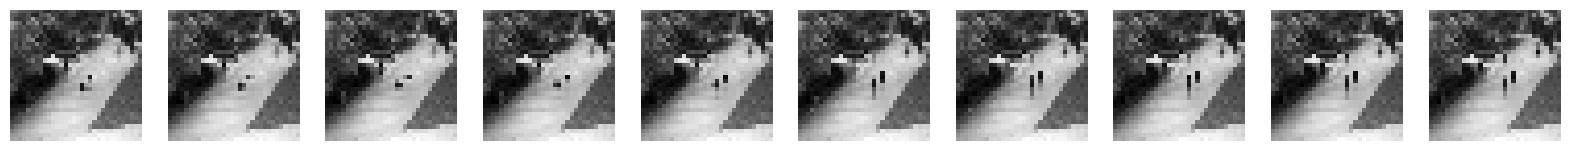

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import random
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import Sequence

# Define the path to the dataset
base_folder = 'C:/Users/USER/Desktop/Esprit 5ERPBI5 S1/Deep Learning/Deep Learning Project 5erpbi5/UCSD_Anomaly_Dataset.v1p2'

# Function to load frames from a folder
def load_frames_from_folder(folder_path, frame_size=(32, 32)):
    frames = []
    tif_files = sorted(glob(os.path.join(folder_path, '*.tif')))

    for file in tif_files:
        frame = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize pixel values
        frames.append(frame)

    return np.array(frames)

# Function to load the dataset
def load_dataset(base_path):
    train_data, test_data = [], []

    for subset in ['UCSDped1', 'UCSDped2']:
        train_path = os.path.join(base_path, subset, 'Train')
        test_path = os.path.join(base_path, subset, 'Test')

        # Process train frames
        for folder in sorted(os.listdir(train_path)):
            folder_path = os.path.join(train_path, folder)
            frames = load_frames_from_folder(folder_path)
            train_data.extend(frames)

        # Process test frames
        for folder in sorted(os.listdir(test_path)):
            folder_path = os.path.join(test_path, folder)
            frames = load_frames_from_folder(folder_path)
            test_data.extend(frames)

    train_data = np.array(train_data).reshape(-1, 32, 32, 1)
    test_data = np.array(test_data).reshape(-1, 32, 32, 1)

    return train_data, test_data

# Load the dataset
train_data, test_data = load_dataset(base_folder)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Function to create sequences of frames
def create_sequences(data, sequence_length=10):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Create sequences of frames
sequence_length = 10
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

print("Train sequences shape:", train_sequences.shape)
print("Test sequences shape:", test_sequences.shape)

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=16, sequence_length=10):
        self.data = data
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.indices = np.arange(len(data) - sequence_length + 1)

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = np.array([self.data[i:i + self.sequence_length] for i in batch_indices])
        batch_data = np.repeat(batch_data, 3, axis=-1)  # Duplicate channels for CNN
        return batch_data, np.zeros((batch_data.shape[0], 1))

# Create data generators
train_generator = DataGenerator(train_data, batch_size=16, sequence_length=sequence_length)
test_generator = DataGenerator(test_data, batch_size=16, sequence_length=sequence_length)

# Define a simple CNN model
def create_cnn_model(input_shape):
    model = Sequential()
    
    # First Convolutional Block
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    # Second Convolutional Block
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    # Third Convolutional Block
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    # Flatten the output
    model.add(TimeDistributed(Flatten()))
    
    # Fully Connected Layers
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

# Create the model
input_shape = (sequence_length, 32, 32, 3)  # Adjusted to 3 channels for CNN
model = create_cnn_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Define the callbacks
checkpoint = ModelCheckpoint('cnn_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=15, callbacks=[checkpoint, early_stopping])

# Visualize some results
def visualize_results(test_sequences, test_generator, model):
    predictions = model.predict(test_generator)

    for i in range(10):  # Display 10 random sequences
        idx = random.randint(0, len(test_sequences) - 1)
        sequence = test_sequences[idx]
        prediction = predictions[idx]

        fig, axes = plt.subplots(1, sequence_length, figsize=(20, 5))
        for j in range(sequence_length):
            axes[j].imshow(sequence[j].reshape(32, 32), cmap='gray')
            axes[j].axis('off')
        plt.suptitle(f'Prediction: {prediction:.4f}')
        plt.show()

# Visualize the results
visualize_results(test_sequences, test_generator, model)


Train data shape: (9350, 32, 32, 1)
Test data shape: (9210, 32, 32, 1)
Train sequences shape: (9341, 10, 32, 32, 1)
Test sequences shape: (9201, 10, 32, 32, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_17             │ (None, 10, 32, 32, 32) │           320 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_18             │ (None, 10, 32, 32, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_19             │ (None, 10, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_20             │ (None, 10, 16, 16, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_21             │ (None, 10, 16, 16, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_22             │ (None, 10, 8, 8, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_23             │ (None, 10, 8, 8, 128)  │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_24             │ (None, 10, 8, 8, 128)  │           512 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_25             │ (None, 10, 4, 4, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_26             │ (None, 10, 2048)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 10, 64)         │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 671,745 (2.56 MB)

 Trainable params: 671,297 (2.56 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 126s 202ms/step - accuracy: 0.9970 - loss: 0.0095 - val_accuracy: 1.0000 - val_loss: 6.1822e-14
Epoch 2/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 118s 203ms/step - accuracy: 1.0000 - loss: 5.2789e-06 - val_accuracy: 1.0000 - val_loss: 1.9533e-17
Epoch 3/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 121s 207ms/step - accuracy: 0.9999 - loss: 2.5127e-04 - val_accuracy: 1.0000 - val_loss: 5.1216e-23
Epoch 4/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 121s 208ms/step - accuracy: 0.9998 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 2.6376e-33
Epoch 5/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 120s 205ms/step - accuracy: 1.0000 - loss: 2.6650e-08 - val_accuracy: 1.0000 - val_loss: 1.9952e-33
Epoch 6/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 122s 210ms/step - accuracy: 1.0000 - loss: 7.9825e-12 - val_accuracy: 1.0000 - val_loss: 8.6142e-34
Epoch 7/15
583/583 ━━━━━━━━━━━━━━━━━━━━ 123s 210ms/step - accuracy: 1.0000 - loss: 1.0015e-05 - val_accuracy: 1.0000 - val_loss: 9.2082e-37
Epoch 8/15
583/583 ━━━━━━━━━

TypeError: unsupported format string passed to numpy.ndarray.__format__

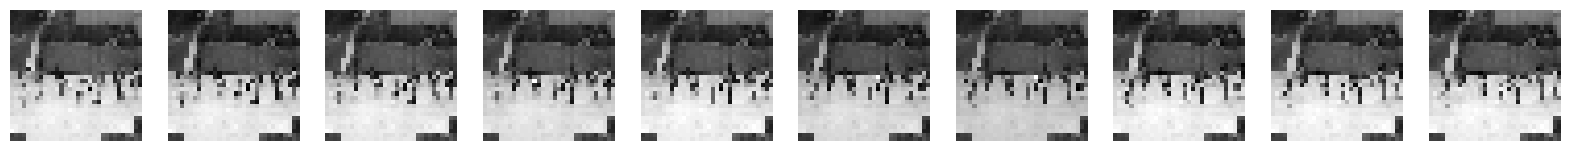

In [ ]:
import os
import time
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import random
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, TimeDistributed, LSTM, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import Sequence

# Define the path to the dataset
base_folder = 'C:/Users/USER/Desktop/Esprit 5ERPBI5 S1/Deep Learning/Deep Learning Project 5erpbi5/UCSD_Anomaly_Dataset.v1p2'

# Function to load frames from a folder
def load_frames_from_folder(folder_path, frame_size=(32, 32)):
    frames = []
    tif_files = sorted(glob(os.path.join(folder_path, '*.tif')))

    for file in tif_files:
        frame = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize pixel values
        frames.append(frame)

    return np.array(frames)

# Function to load the dataset
def load_dataset(base_path):
    train_data, test_data = [], []

    for subset in ['UCSDped1', 'UCSDped2']:
        train_path = os.path.join(base_path, subset, 'Train')
        test_path = os.path.join(base_path, subset, 'Test')

        # Process train frames
        for folder in sorted(os.listdir(train_path)):
            folder_path = os.path.join(train_path, folder)
            frames = load_frames_from_folder(folder_path)
            train_data.extend(frames)

        # Process test frames
        for folder in sorted(os.listdir(test_path)):
            folder_path = os.path.join(test_path, folder)
            frames = load_frames_from_folder(folder_path)
            test_data.extend(frames)

    train_data = np.array(train_data).reshape(-1, 32, 32, 1)
    test_data = np.array(test_data).reshape(-1, 32, 32, 1)

    return train_data, test_data

# Load the dataset
train_data, test_data = load_dataset(base_folder)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Function to create sequences of frames
def create_sequences(data, sequence_length=10):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Create sequences of frames
sequence_length = 10
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

print("Train sequences shape:", train_sequences.shape)
print("Test sequences shape:", test_sequences.shape)

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=16, sequence_length=10):
        self.data = data
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.indices = np.arange(len(data) - sequence_length + 1)

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = np.array([self.data[i:i + self.sequence_length] for i in batch_indices])
        batch_data = np.expand_dims(batch_data, axis=-1)  # Use 1 channel (grayscale) instead of repeating to 3
        return batch_data, np.zeros((batch_data.shape[0], 1))

# Create data generators
train_generator = DataGenerator(train_data, batch_size=16, sequence_length=sequence_length)
test_generator = DataGenerator(test_data, batch_size=16, sequence_length=sequence_length)

# Define the improved CNN model with BatchNormalization and multiple LSTM layers
def create_cnn_model(input_shape):
    model = Sequential()
    
    # First Convolutional Block
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(BatchNormalization()))  # Added BatchNorm
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    # Second Convolutional Block
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))  # Added BatchNorm
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    # Third Convolutional Block
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(BatchNormalization()))  # Added BatchNorm
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    # Flatten the output
    model.add(TimeDistributed(Flatten()))
    
    # LSTM Layers
    model.add(LSTM(64, activation='relu', return_sequences=True))  # First LSTM with return_sequences=True
    model.add(LSTM(64, activation='relu', return_sequences=False))  # Second LSTM
    
    # Fully Connected Layers
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    return model

# Create the model
input_shape = (sequence_length, 32, 32, 1)  # Adjusted to 1 channel for grayscale input
model = create_cnn_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Define the callbacks
# Define the callbacks
checkpoint = ModelCheckpoint(f'cnn_model_{int(time.time())}.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=15, callbacks=[checkpoint, early_stopping])

# Visualize some results
def visualize_results(test_sequences, test_generator, model):
    predictions = model.predict(test_generator)

    for i in range(10):  # Display 10 random sequences
        idx = random.randint(0, len(test_sequences) - 1)
        sequence = test_sequences[idx]
        prediction = predictions[idx]

        fig, axes = plt.subplots(1, sequence_length, figsize=(20, 5))
        for j in range(sequence_length):
            axes[j].imshow(sequence[j].reshape(32, 32), cmap='gray')
            axes[j].axis('off')
        plt.suptitle(f'Prediction: {prediction:.4f}')
        plt.show()

# Visualize the results
visualize_results(test_sequences, test_generator, model)


In [ ]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt
import random
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, TimeDistributed, LSTM, RepeatVector, Reshape, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import Sequence

# Define the path to the dataset
base_folder = 'C:/Users/USER/Desktop/Esprit 5ERPBI5 S1/Deep Learning/Deep Learning Project 5erpbi5/UCSD_Anomaly_Dataset.v1p2'

# Function to load frames from a folder
def load_frames_from_folder(folder_path, frame_size=(32, 32)):
    frames = []
    tif_files = sorted(glob(os.path.join(folder_path, '*.tif')))

    for file in tif_files:
        frame = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        frame = cv2.resize(frame, frame_size)
        frame = frame / 255.0  # Normalize pixel values
        frames.append(frame)

    return np.array(frames)

# Function to load the dataset
def load_dataset(base_path):
    train_data, test_data = [], []

    for subset in ['UCSDped1', 'UCSDped2']:
        train_path = os.path.join(base_path, subset, 'Train')
        test_path = os.path.join(base_path, subset, 'Test')

        # Process train frames
        for folder in sorted(os.listdir(train_path)):
            folder_path = os.path.join(train_path, folder)
            frames = load_frames_from_folder(folder_path)
            train_data.extend(frames)

        # Process test frames
        for folder in sorted(os.listdir(test_path)):
            folder_path = os.path.join(test_path, folder)
            frames = load_frames_from_folder(folder_path)
            test_data.extend(frames)

    train_data = np.array(train_data).reshape(-1, 32, 32, 1)
    test_data = np.array(test_data).reshape(-1, 32, 32, 1)

    return train_data, test_data

# Load the dataset
train_data, test_data = load_dataset(base_folder)
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

# Function to create sequences of frames
def create_sequences(data, sequence_length=10):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequences.append(data[i:i + sequence_length])
    return np.array(sequences)

# Create sequences of frames
sequence_length = 10
train_sequences = create_sequences(train_data, sequence_length)
test_sequences = create_sequences(test_data, sequence_length)

print("Train sequences shape:", train_sequences.shape)
print("Test sequences shape:", test_sequences.shape)

# Data generator class
class DataGenerator(Sequence):
    def __init__(self, data, batch_size=16, sequence_length=10):
        self.data = data
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.indices = np.arange(len(data) - sequence_length + 1)

    def __len__(self):
        return int(np.floor(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = np.array([self.data[i:i + self.sequence_length] for i in batch_indices])
        batch_data = np.repeat(batch_data, 3, axis=-1)  # Duplicate channels for CNN
        return batch_data, batch_data

# Create data generators
train_generator = DataGenerator(train_data, batch_size=16, sequence_length=sequence_length)
test_generator = DataGenerator(test_data, batch_size=16, sequence_length=sequence_length)

# Define the autoencoder model
def create_autoencoder_model(input_shape):
    model = Sequential()

    # Encoder
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_shape))
    model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), padding='same')))

    # Bottleneck
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, activation='relu', return_sequences=False))

    # Decoder
    model.add(RepeatVector(sequence_length))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(128 * 4 * 4, activation='relu')))
    model.add(TimeDistributed(Reshape((4, 4, 128))))
    model.add(TimeDistributed(UpSampling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(UpSampling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(UpSampling2D((2, 2))))
    model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same')))
    model.add(TimeDistributed(Conv2D(3, (3, 3), activation='sigmoid', padding='same')))

    return model

# Create the model
input_shape = (sequence_length, 32, 32, 3)  # Adjusted to 3 channels for CNN
model = create_autoencoder_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
model.summary()

# Define the callbacks
checkpoint = ModelCheckpoint('autoencoder_model.keras', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=15, callbacks=[checkpoint, early_stopping])

# Visualize some results
def visualize_results(test_sequences, test_generator, model):
    predictions = model.predict(test_generator)

    for i in range(10):  # Display 10 random sequences
        idx = random.randint(0, len(test_sequences) - 1)
        sequence = test_sequences[idx]
        prediction = predictions[idx]

        fig, axes = plt.subplots(2, sequence_length, figsize=(20, 5))
        for j in range(sequence_length):
            axes[0, j].imshow(sequence[j].reshape(32, 32), cmap='gray')
            axes[0, j].axis('off')
            axes[1, j].imshow(prediction[j].reshape(32, 32), cmap='gray')
            axes[1, j].axis('off')
        plt.suptitle(f'Sequence {i + 1}: Original (top) vs. Reconstructed (bottom)')
        plt.show()

# Visualize the results
visualize_results(test_sequences, test_generator, model)


Train data shape: (9350, 32, 32, 1)
Test data shape: (9210, 32, 32, 1)
Train sequences shape: (9341, 10, 32, 32, 1)
Test sequences shape: (9201, 10, 32, 32, 1)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_56             │ (None, 10, 32, 32, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_57             │ (None, 10, 16, 16, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_58             │ (None, 10, 16, 16, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_59             │ (None, 10, 8, 8, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_60             │ (None, 10, 8, 8, 128)  │        73,856 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_61             │ (None, 10, 4, 4, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_62             │ (None, 10, 2048)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_63             │ (None, 10, 2048)       │       133,120 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_64             │ (None, 10, 4, 4, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_65             │ (None, 10, 8, 8, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_66             │ (None, 10, 8, 8, 128)  │       147,584 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_67             │ (None, 10, 16, 16,     │             0 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_68             │ (None, 10, 16, 16, 64) │        73,792 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_69             │ (None, 10, 32, 32, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_70             │ (None, 10, 32, 32, 32) │        18,46

 Total params: 1,041,027 (3.97 MB)

 Trainable params: 1,041,027 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
550/583 ━━━━━━━━━━━━━━━━━━━━ 12s 369ms/step - loss: 0.0215

KeyboardInterrupt: 